<a href="https://colab.research.google.com/github/agroimpacts/VegMapper/blob/dev-calval-simplify/create_sample.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Calculating Sample Sizes for Land Cover Assessment

This notebook walks through steps to calculate sample size and download sample points to assess accuracy of a land cover strata layer.

In our example, we will be calculating sample sizes for presence and absence of oil palm fields in Ucayali, Peru. The notebook can calculate reference sample sizes, or reference + training/validation sample sizes.

This notebook requires the following files/information:
- A land cover strata image including classes of **presence** and **absence** for the category of interest. The strata image should be a Google Earth Engine (GEE) image asset of integer type.
- A pair of lists for user defined **presence** and **absence** categories.
- A sampling method with its sampling parameters (see examples)
- A Google Drive account for exporting the final shapefile and CSV files.

The final sample points are exported in Collect Earth Online (CEO) format.

# Overview of Steps

0. Install packages and set project options
1. Load and analyze the stratification layer for collecting the sample
2. Determine the **presence** and **absence** sample sizes required for the reference sample
3. Include the size requirements for the training and validation samples
4. Distribute sample points among sub-classes
5. Perform sampling on GEE
6. Map the sample over the stratification layer
7. Export the sample to Google Drive
8. Format the sample for a CEO project



## Workflow details

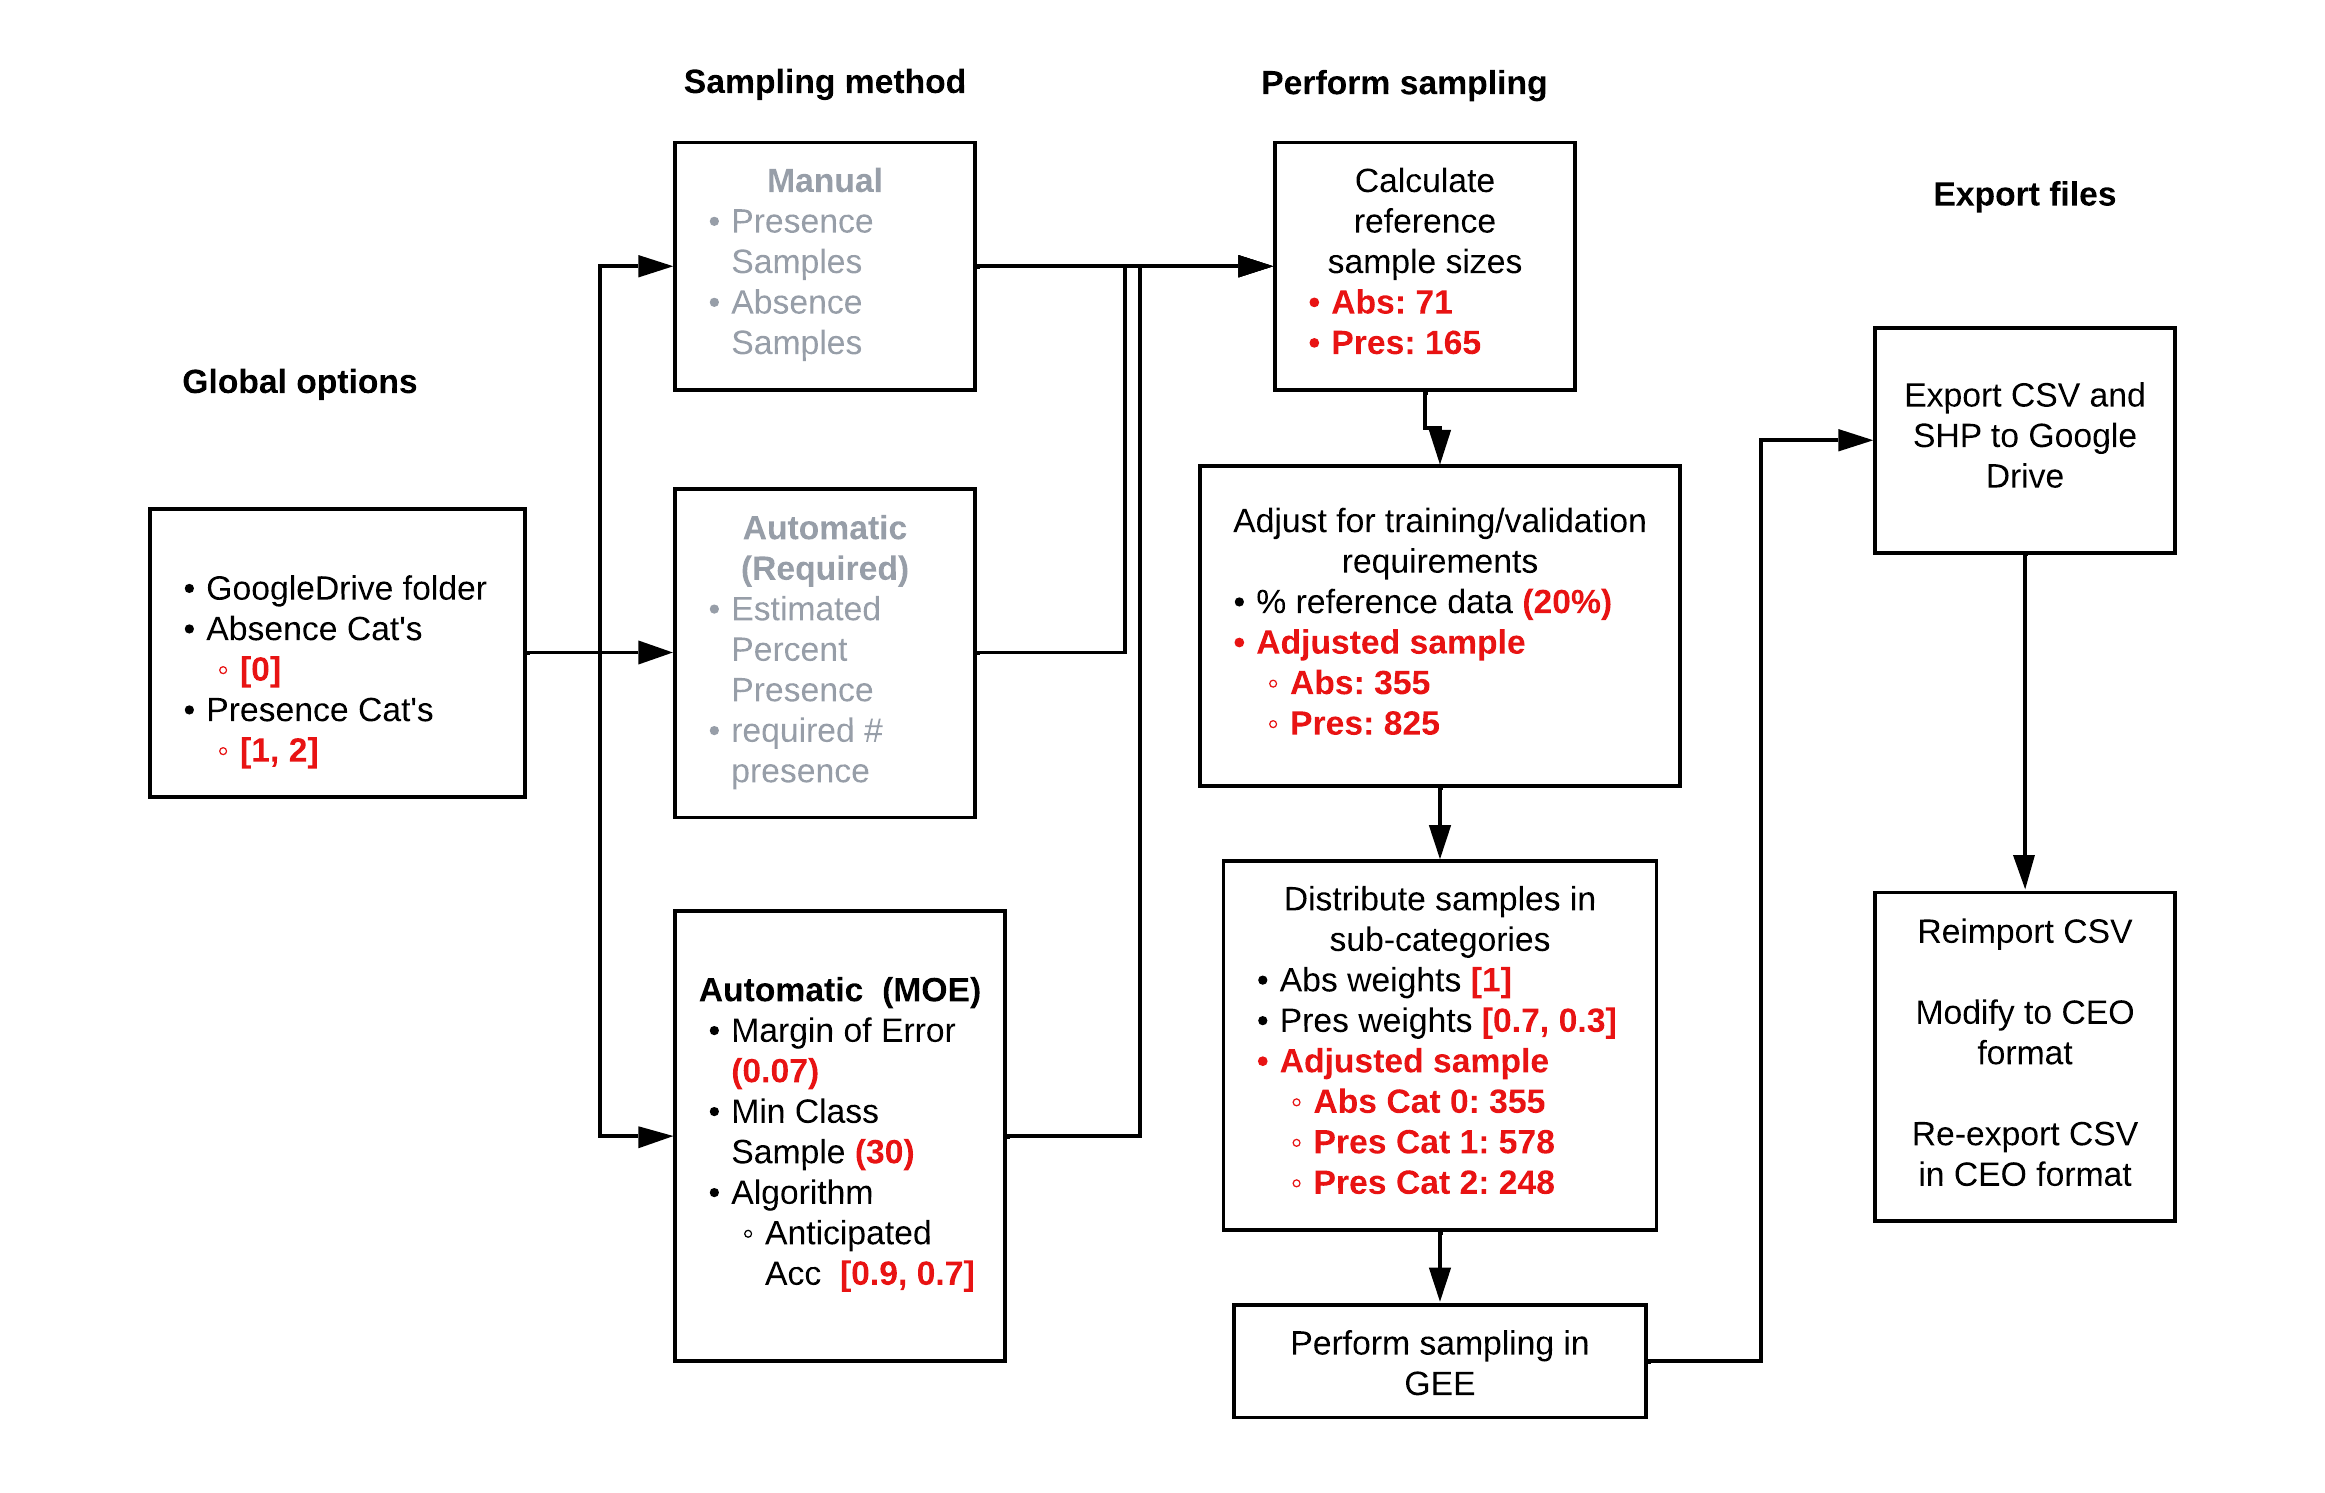

# Step 0: Earth Engine Python API Colab Setup

Several libraries are required to be loaded to run this notebook.

In addition, you need to authenticate your Google account to load data from Google Earth Engine (GEE).

Press the run button next to "Setup code" below to mount your Google Drive folder, import `VegMapper` (note it will install into a default "repos" directory in your Google Drive, unless you change it in the code block), and authenticate your EarthEngine account. Please respond to the prompts as they arise. You can unfold the code block if you want to inspect the code and change default paths.

In [ ]:
#@title #### Setup code
## Mount Drive
from google.colab import drive
root = '/content/gdrive'
drive.mount(root)

## Clone and/or update VegMapper
import os
from datetime import datetime as dt
repo_path = f"{root}/MyDrive/repos"
clone_path = 'https://github.com/agroimpacts/VegMapper.git'
if not os.path.exists(repo_path):
    print(f"Making {repo_path}")
    os.makedirs(repo_path, exist_ok=True)

if not os.path.exists(f"{repo_path}/VegMapper"):
    !git -C "{repo_path}" clone "{clone_path}"
else:
    !git -C "{repo_path}/VegMapper" pull

os.chdir(f"{repo_path}/VegMapper")

# Import sample_utils function
from vegmapper.calval.sample_utils import *

# EE authentication
ee.Authenticate()
# Initialize the library.
ee.Initialize()

# Step 1. Import, analyze, and view the stratification layers

The code below imports a strata image from a Google Earth Engine (GEE) asset that contains land cover information from Ucayali, Peru. Then, the code retrieves the metadata of this image and calculates the category statistics.

The function `analyze_strata_image()` returns three variables:

strata: The strata image (an ee.Image object).
strata_df: The category statistics (a Pandas dataframe).
misc: A Python dictionary containing miscellaneous information such as minimum and maximum category values, bounding box (bbox), and scale.


In [14]:
asset = "users/michaeljcecil/Updated_Strata_v2"
strata, strata_df, misc = analyze_strata_image(asset)
strata_df

Retriving GEE image...
Accessing image metadata...
Analyzing image categories...
Done!


,Cat,pixel_ct
0,1,4507
1,2,4919
2,3,111589315
3,4,6557079
4,5,133358


## Map the strata

The code below maps the strata. The colors can be changed by using a different palette.

In [15]:
# display the strata map with default palette
display(strata, misc)
# Add a custom palette
# palette = ['000000', '111111', '222222','333333', 'e32a1c', 'fdcf6f','1f28b4']
# display(strata, misc, palette=palette)

Map(center=[-9.354459533546633, -73.2212695578606], controls=(WidgetControl(options=['position', 'transparent_…

# Step 2. Determine the size of the **presence** and **absence** samples

There are three possible methods. Depending on the sampling design method, we may choose to specify the sample size for presence and absence either arbitrarily or based on prior knowledge from the strata image. If the latter approach is chosen, and if there are multiple categories representing either presence or absence, we need to specify which categories represent presence, and which absence.

In [ ]:
# @title Enter presence and absence categories
x = input(f"Which categories represent the presence class? \n If there are "\
          "more than one separate by a comma. \n If you are using the layer " \
          "provided with this example, enter 1,2: \n")

presence_cats = [int(x) for x in x.split(",")]

x = input(f"Which categories represent the absence class? \n If there are "\
          "more than one separate by a comma. \n If you are using the layer " \
          "provided with this example, enter 5: \n")
absence_cats = [int(x) for x in x.split(",")]

# Save a copy of the original multi-category strata
strata_df_mltcat = strata_df.copy()

# Specify absence and presence categories
# absenceCats, presenceCats = [5], [1, 2]

# Consolidate multi-categories to binary presence absence
strata_df_bincat = consolidate(strata_df, absence_cats, presence_cats)

print("\n Count and percent of the consolidated binary classes")
print(strata_df_bincat)

# Step 3. Calculate binary reference sample size

There are 3 possible methods, including:

1. **Manual**: the number for each of the two classes is determined entirely by you
2. **Automatic: adjust required number**: Adjusts a required sample size for each class according to the estimated areas of the presence and absence classes
3. **Automatic: margin of error**: Calculates sample size statistically This has two selection algorithms (see methods appendix at the end for more details in these approaches). This method is the default option used here.



## Draw sample using default MOE approach

In [79]:
cfg_StehmanFoody = {"MarginOfError":0.07,  # desired margin of error
                    "ConfidenceLevel":0.95,  # desired confidence level
                    "MinimumClassSample": 30,  # minimum sample size
                    "anticipatedAcc":[0.90, 0.7]}  # assumed accuracy of classes

strata_df_bincat = automatic_moe(strata_df_bincat, MOE_Algorithm="StehmanFoody",
                                 **cfg_StehmanFoody)
print(strata_df_bincat)

Using Stehman Foody
   Cat  pixel_ct  pct_area    p   nh  nh_adjusted
0    0    133358    93.398  0.9   70           70
1    1      9426     6.602  0.7  164          164


## Other methods

In [ ]:
#@title #### Alternate MOE-approach
# Using the Olofsson algorithm
cfg_Olofsson = {"MarginOfError":0.07,
                "ConfidenceLevel":0.95,
                "MinimumClassSample":30,
                "CategoryOfInterest":1,
                "mappingAcc":[0.000000001, 0.7]}

strata_df_bincat = automatic_moe(strata_df_bincat, MOE_Algorithm="Olofsson",
                                 **cfg_Olofsson)
print(strata_df_bincat)

In [ ]:
#@title #### Manual method
# Arbitary sample size for presence and absence from user input.
strata_df_bincat = manual(strata_df_bincat, absenceSamples=1000,
                          presenceSamples=1000)
print(strata_df_bincat)

In [ ]:
#@title ### Automatic required number
strata_df_bincat = automatic_requiredNumber(
    strata_df_bincat, 1000, 0.6, 1000, 1
)
print(strata_df_bincat)

# Step 4. Include Training/Validation requirements

Adjust the overall sample size based on training/validation requirement, based on the proportion that the reference sample should represent of the total sample size, e.g. 0.2 for this example.

In [81]:
x = input(f"Enter the proportion of the total sample \n"\
          "that the reference sample represents, e.g. 0.2: \n")
strata_df_bincat['nh_adjusted'] = (strata_df_bincat['nh_adjusted'] / float(x))\
    .astype(int).tolist()

Enter the proportion of the total sample 
that the reference sample represents, e.g. 0.2: 
0.2


In [83]:
strata_df_bincat

,Cat,pixel_ct,pct_area,p,nh,nh_adjusted
0,0,133358,93.398,0.9,70,350
1,1,9426,6.602,0.7,164,820


# Step 5. Distribute the number of sample points among sub-classes

This code distributes the absence and presence samples among sub-categories, based on the **absenceSampleWeights** and **presenceSampleWeights** parameters.


In [84]:
# distribute sample in strata_df_mltcat
strata_df_mltcat = distribute_sample(
    strata_df_bincat,
    strata_df_mltcat,
    absence_cats,
    presence_cats,
    absenceSampleWeights=[1],
    presenceSampleWeights=[0.3, 0.7])

print(strata_df_mltcat)

distributing sample size for sub-classes...
   Cat  pixel_ct  nh_final
0    1      4507       246
1    2      4919       574
2    5    133358       350


We want to include the categories that are not considered in our sample design because the GEE stratifiedSample() function requires an explicit specification of 0 for categories that are not of interest.


In [90]:
strata_df_mltcat = unwant_cat_samples_zero(strata_df_mltcat)
print(strata_df_mltcat)

   Cat  pixel_ct  nh_final
0    1    4507.0       246
1    2    4919.0       574
2    3       NaN         0
3    4       NaN         0
4    5  133358.0       350


# Step 6. Perform Sampling in GEE

This code uses the GEE API to calculate the location of all sample points.

These points are then displayed in a map, with presence samples in <font color='red'>**red**</font> and absence samples in <font color='blue'>**blue**</font>.

In [86]:
seed = 9999

# numPoints=10 is a placeholder specification. It will be overwritten by
# classPoints, which contains the sample size for sampling.
samples = strata.stratifiedSample(
  numPoints=10,
  classBand=misc['classBand'],
  projection='EPSG:3857',
  classValues=ee.List(strata_df_mltcat['Cat'].tolist()),
  classPoints=ee.List(strata_df_mltcat['nh_final'].tolist()),
  geometries=True,
  scale=30,
  seed=seed,
  tileScale=1)

# Step 7. Confirm # of samples per category

This code iterates through each class of the original strata layer and prints the number of points per class.

**Note that some if a category does not have enough pixels to meet the sample size requirements, then there may be fewer sample points for this category.**

In [ ]:
samples_presence = samples.filter(
    ee.Filter.inList(misc['classBand'], presence_cats)
)
samples_absence = samples.filter(
    ee.Filter.inList(misc['classBand'], absence_cats)
)
display_samples(strata, misc, samples_presence, samples_absence)

In [88]:
# Get a list of feature dictionaries with lat and lon properties
samples_df = sampleFC_to_csv(samples)
timestamp = dt.now().strftime("%Y_%m_%d_%H%M%S")

# Step 8. Export samples to Google Drive

This code exports the sample points to your Google Drive folder. The points are exported as a shapefile "sample_points_SHP", and as a CSV file "sample_points_CSV".



First, mount your Google Drive folder and create the directory for output (this step is necessary otherwise the EE functions will write the same folder twice)

In [ ]:
## mount your Google Drive to access files
drive.mount('/content/drive')

Create output folder

In [ ]:
outpath = f"/content/drive/MyDrive/{gdrive_folder}"
if not os.path.isdir(outpath):
    print(f"Creating output folder {gdrive_folder}")
    os.makedirs(outpath, exist_ok=True)

The "Polling for task" message displays every 5 seconds. Once it stops displaying, your files should be ready.

In [ ]:
samples_df.to_csv('test_csv_output.csv')